<a href="https://colab.research.google.com/github/budhitha/Sales-data-clean-project/blob/master/258269T_Budhitha_Lab2_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google drive stored data downloading https://drive.google.com/file/d/16JnE8WPt79pT2a2pAF_mYUByj_erbGXP/view?usp=sharing
!gdown --id 16JnE8WPt79pT2a2pAF_mYUByj_erbGXP

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16JnE8WPt79pT2a2pAF_mYUByj_erbGXP
To: /content/sales_need_cleaning.csv
100% 550k/550k [00:00<00:00, 111MB/s]


In [2]:
# modules we'll use
import pandas as pd
import numpy as np

In [3]:
# read in all our data
sales_data = pd.read_csv("/content/sales_need_cleaning.csv")

In [4]:
sales_data.head(100)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
95,TXN_8268061,Salad,3,5.0,15.0,ERROR,Takeaway,2023-08-20
96,TXN_5220895,Salad,5,5.0,25.0,Cash,In-store,2023-06-10
97,TXN_3085509,Coffee,4,2.0,8.0,Digital Wallet,In-store,2023-04-15
98,TXN_9999113,Juice,4,3.0,12.0,Cash,Takeaway,2023-05-27


In [5]:
sales_data.shape

(10000, 8)

In [6]:
# get the number of missing data points per column with includint 'ERROR' and 'UNKNOWN' values
initial_missing_values_count = sales_data.isnull().sum()

# look at the # of missing points in the first ten columns
initial_missing_values_count[0:8]

,0
Transaction ID,0
Item,333
Quantity,138
Price Per Unit,179
Total Spent,173
Payment Method,2579
Location,3265
Transaction Date,159


In [7]:
# get the number of missing data points per column with includint 'ERROR' and 'UNKNOWN' values
sales_data = sales_data.replace(['ERROR', 'UNKNOWN'], np.nan)

# look at the # of missing points in the columns
sales_data.isnull().sum()[0:8]

,0
Transaction ID,0
Item,969
Quantity,479
Price Per Unit,533
Total Spent,502
Payment Method,3178
Location,3961
Transaction Date,460


In [8]:
# how many total missing values do we have?
total_cells = np.prod(sales_data.shape)
total_missing = sales_data.isnull().sum().sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)


12.6025


Helping task for Convert columns into numeric columns for calculations

In [9]:
# Convert 'Total Spent', 'Quantity', and 'Price Per Unit' to numeric, coercing errors
sales_data['Total Spent'] = pd.to_numeric(sales_data['Total Spent'], errors='coerce')
sales_data['Quantity'] = pd.to_numeric(sales_data['Quantity'], errors='coerce')
sales_data['Price Per Unit'] = pd.to_numeric(sales_data['Price Per Unit'], errors='coerce')

Fill Price Per Unit according to the Item name

In [10]:
# Calculate the median price per unit for each item
median_price_per_item = sales_data.groupby('Item')['Price Per Unit'].median()

# Fill the null values in 'Price Per Unit' with the median price per unit for each item
sales_data['Price Per Unit'] = sales_data.apply(
    lambda row: median_price_per_item[row['Item']] if pd.isnull(row['Price Per Unit']) and row['Item'] in median_price_per_item.index else row['Price Per Unit'],
    axis=1
)

# Display the number of remaining missing values in 'Price Per Unit'
print(f"Number of missing values in 'Price Per Unit' after filling: {sales_data['Price Per Unit'].isnull().sum()}")

Number of missing values in 'Price Per Unit' after filling: 54


Calculate Price Per Unit null values by Total Spent column dividing Quantity value

In [11]:
# Calculate the divition of 'Total Spent' by 'Quantity' where 'Price Per Unit' is NaN
calculated_unit_price = sales_data['Total Spent'] / sales_data['Quantity']

# Fill the NaN values in 'Price Per Unit' with the calculated values
sales_data['Price Per Unit'].fillna(calculated_unit_price, inplace=True)

# Display the updated 'Price Per Unit' column and check for remaining missing values
display(sales_data['Price Per Unit'].unique())
print(f"Number of missing values in 'Price Per Unit' after filling: {sales_data['Price Per Unit'].isnull().sum()}")

/tmp/ipython-input-2901143091.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data['Price Per Unit'].fillna(calculated_unit_price, inplace=True)


array([2. , 3. , 1. , 5. , 4. , 1.5, nan])

Number of missing values in 'Price Per Unit' after filling: 6


Calculate Total Spent value by multiplying Quantity by Price Per Unit column

In [12]:
# Calculate the product of 'Quantity' and 'Price Per Unit' where 'Total Spent' is NaN
calculated_spent = sales_data['Quantity'] * sales_data['Price Per Unit']

# Fill the NaN values in 'Total Spent' with the calculated values
sales_data['Total Spent'].fillna(calculated_spent, inplace=True)

# Display the updated 'Total Spent' column and check for remaining missing values
display(sales_data['Total Spent'].unique())
print(f"Number of missing values in 'Total Spent' after filling: {sales_data['Total Spent'].isnull().sum()}")

/tmp/ipython-input-3792085049.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data['Total Spent'].fillna(calculated_spent, inplace=True)


array([ 4. , 12. , 10. , 20. ,  9. , 16. , 15. , 25. ,  8. ,  5. ,  3. ,
        6. ,  2. ,  1. ,  7.5,  4.5,  1.5,  nan])

Number of missing values in 'Total Spent' after filling: 23


Fill Item name according to the Price Per Unit price

In [13]:
# Group by 'Price Per Unit' and find the most frequent 'Item' for each price
typical_item_per_price = sales_data.groupby('Price Per Unit')['Item'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Display the typical item per price mapping
display(typical_item_per_price)

{1.0: 'Cookie',
 1.5: 'Tea',
 2.0: 'Coffee',
 3.0: 'Juice',
 4.0: 'Sandwich',
 5.0: 'Salad'}

In [14]:
def replace_item_with_typical(row):
    """
    Replaces null items based on the 'Price Per Unit'
    using a predefined typical item per price mapping.

    Args:
        row: A pandas Series representing a row of the DataFrame.

    Returns:
        The corrected item string or the original item string if no replacement is made.
    """
    if pd.isnull(row['Item']): # Check if the item is null
        price = row['Price Per Unit']
        if price in typical_item_per_price:
            return typical_item_per_price[price]
    return row['Item']

# Display the function definition
print(replace_item_with_typical.__doc__)


    Replaces null items based on the 'Price Per Unit'
    using a predefined typical item per price mapping.

    Args:
        row: A pandas Series representing a row of the DataFrame.

    Returns:
        The corrected item string or the original item string if no replacement is made.
    


In [15]:
sales_data['Item'] = sales_data.apply(replace_item_with_typical, axis=1)
display(sales_data.head())

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [16]:
# Display the updated 'Item' column and check for remaining missing values
display(sales_data['Item'].unique())
print(f"Number of missing values in 'Item' after filling: {sales_data['Item'].isnull().sum()}")

array(['Coffee', 'Cake', 'Cookie', 'Salad', 'Smoothie', 'Juice',
       'Sandwich', 'Tea', nan], dtype=object)

Number of missing values in 'Item' after filling: 6


Calculate Quantity null values by Total Spent column dividing Price Per Unit value

In [17]:
# Calculate the divition of 'Total Spent' by 'Price Per Unit' where 'Quantity' is NaN
calculated_quantity = sales_data['Total Spent'] / sales_data['Price Per Unit']

# Fill the NaN values in 'Quantity' with the calculated values
sales_data['Quantity'].fillna(calculated_quantity, inplace=True)

# Display the updated 'Quantity' column and check for remaining missing values
display(sales_data['Quantity'].unique())
print(f"Number of missing values in 'Quantity' after filling: {sales_data['Quantity'].isnull().sum()}")

/tmp/ipython-input-833176485.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data['Quantity'].fillna(calculated_quantity, inplace=True)


array([ 2.,  4.,  5.,  3.,  1., nan])

Number of missing values in 'Quantity' after filling: 23


Fill null values for 'Payment Method' and 'Location' columns with Random sampling method.

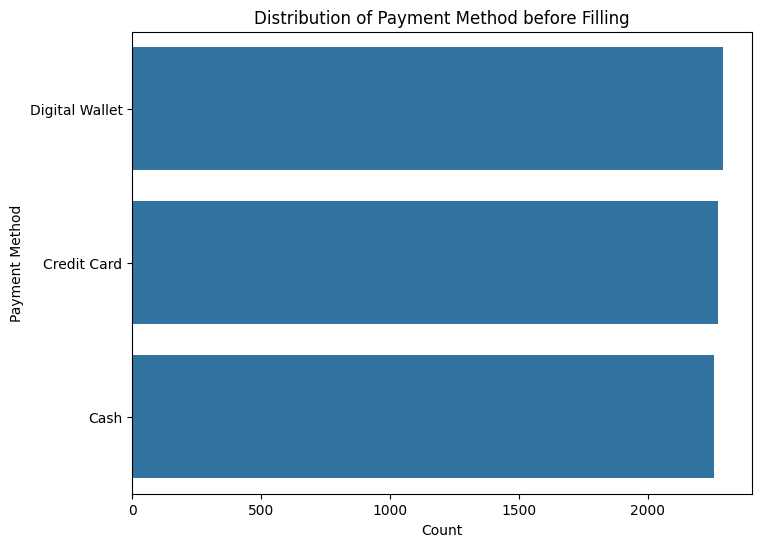

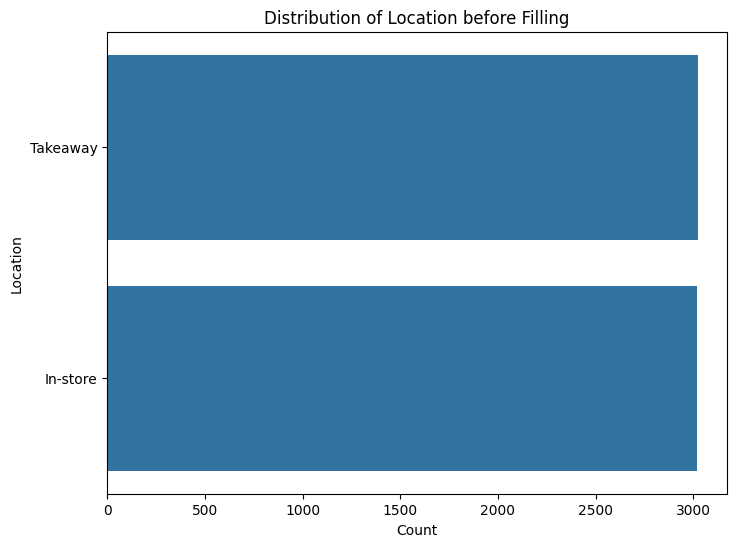

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of 'Payment Method' before filling
plt.figure(figsize=(8, 6))
sns.countplot(data=sales_data, y='Payment Method', order=sales_data['Payment Method'].value_counts().index)
plt.title('Distribution of Payment Method before Filling')
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.show()

# Visualize the distribution of 'Location' before filling
plt.figure(figsize=(8, 6))
sns.countplot(data=sales_data, y='Location', order=sales_data['Location'].value_counts().index)
plt.title('Distribution of Location before Filling')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

In [19]:
def random_sample_fillna(series, freq):
    """
    Fills NaN values in a pandas Series by randomly sampling from a frequency distribution.

    Args:
        series: The pandas Series with NaN values to fill.
        freq: A pandas Series representing the frequency distribution of the non-null values.

    Returns:
        The Series with NaN values filled by random sampling.
    """
    null_idx = series.isnull()
    num_null = null_idx.sum()
    if num_null == 0:
        return series

    # Sample from the frequency distribution
    filled_values = np.random.choice(freq.index, size=num_null, p=freq.values)

    # Fill the null values
    series.loc[null_idx] = filled_values

    return series

# Display the function definition
print(random_sample_fillna.__doc__)


    Fills NaN values in a pandas Series by randomly sampling from a frequency distribution.

    Args:
        series: The pandas Series with NaN values to fill.
        freq: A pandas Series representing the frequency distribution of the non-null values.

    Returns:
        The Series with NaN values filled by random sampling.
    


In [20]:
# Calculate frequency distribution for 'Payment Method' (excluding nulls and normalizing)
payment_method_freq = sales_data['Payment Method'].value_counts(normalize=True)

# Calculate frequency distribution for 'Location' (excluding nulls and normalizing)
location_freq = sales_data['Location'].value_counts(normalize=True)

# Fill missing values in 'Payment Method' using random sampling based on frequency
sales_data['Payment Method'] = random_sample_fillna(sales_data['Payment Method'].copy(), payment_method_freq)

# Fill missing values in 'Location' using random sampling based on frequency
sales_data['Location'] = random_sample_fillna(sales_data['Location'].copy(), location_freq)


# Display the number of remaining missing values in 'Payment Method' and 'Location'
print(f"Number of missing values in 'Payment Method' after filling: {sales_data['Payment Method'].isnull().sum()}")
print(f"Number of missing values in 'Location' after filling: {sales_data['Location'].isnull().sum()}")

Number of missing values in 'Payment Method' after filling: 0
Number of missing values in 'Location' after filling: 0


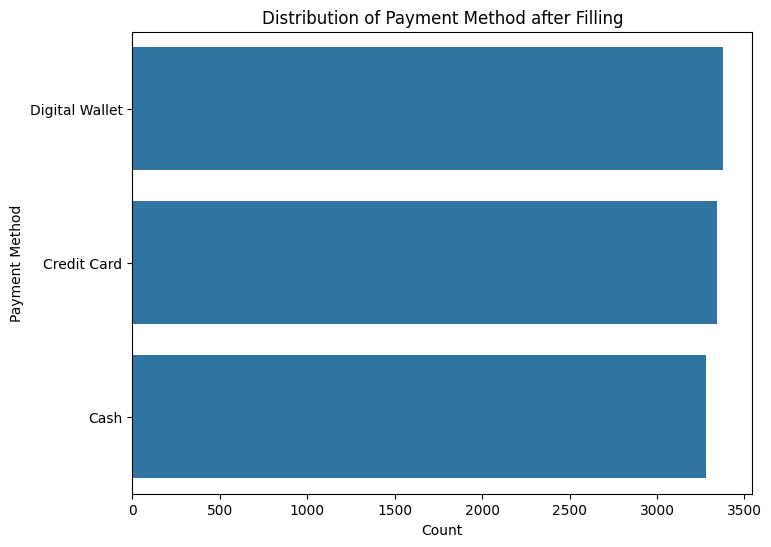

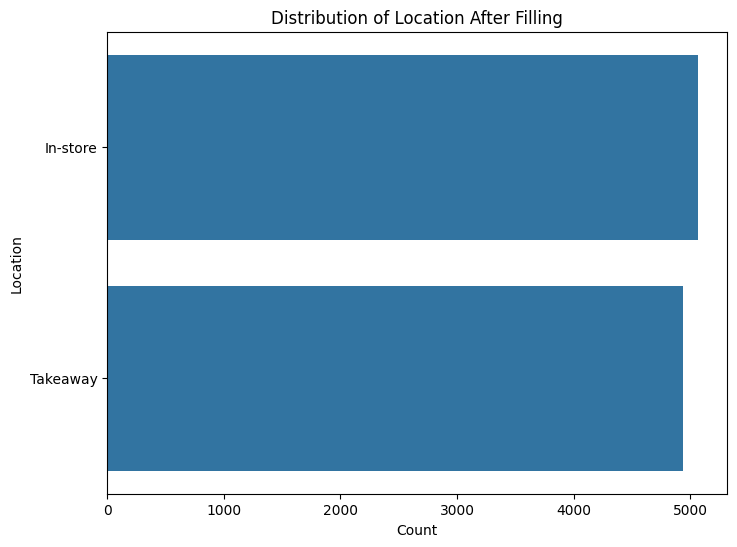

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of 'Payment Method' after filling
plt.figure(figsize=(8, 6))
sns.countplot(data=sales_data, y='Payment Method', order=sales_data['Payment Method'].value_counts().index)
plt.title('Distribution of Payment Method after Filling')
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.show()

# Visualize the distribution of 'Location' after filling
plt.figure(figsize=(8, 6))
sns.countplot(data=sales_data, y='Location', order=sales_data['Location'].value_counts().index)
plt.title('Distribution of Location After Filling')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

In [22]:
# look at the # of missing points in the columns
sales_data.isnull().sum()[0:8]

,0
Transaction ID,0
Item,6
Quantity,23
Price Per Unit,6
Total Spent,23
Payment Method,0
Location,0
Transaction Date,460


In [23]:
total_missing = sales_data.isnull().sum().sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.6475


In [26]:
display(sales_data.head(20))

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5.0,4.0,20.0,Credit Card,In-store,2023-03-31
6,TXN_4433211,Juice,3.0,3.0,9.0,Cash,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4.0,4.0,16.0,Cash,Takeaway,2023-10-28
8,TXN_4717867,Juice,5.0,3.0,15.0,Cash,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5.0,4.0,20.0,Credit Card,In-store,2023-12-31


Save cleaned dataset to CSV file

In [24]:
# save file
sales_data.to_csv("/content/258269T_Budhitha_Lab2_data.csv")

